Predicting baby name sex using PyTorch for Logistic Regression

### References

- [Logistic Regression with PyTorch](https://proai.org/pytorch-logistic-regression) by [Denny Loevlie](https://twitter.com/DennisLoevlie)
- [PyTorch OO design compared with SkLearn](https://jeancochrane.com/blog/pytorch-functional-api) by [Jean Cochrane](https://JeanCochrane.com)
- [Building Your First Network in PyTorch](https://t.co/m9I4e0tfrC) by [Ta-Ying Cheng](https://www.linkedin.com/in/tim-ta-ying-cheng-411857139/)
- [data.world US baby names since 1880](https://data.world/ssa/baby-names-for-us-states-territories)



In [1]:
import numpy as np
import pandas as pd
# neither year nor len are statistically significant predictors of sex
from pathlib import Path

In [2]:
pd.options.display.max_rows=7

In [3]:
CWD = Path('.').absolute().resolve()
DATA_DIR_NAME = '.nlpia2-data'
DATA_FILE = 'baby-names-region.csv.gz'
CWD

PosixPath('/home/hobs/code/tangibleai/nlpia2/src/nlpia2/ch05')

In [4]:
parent = CWD
data_dir = parent / DATA_DIR_NAME 
filepath = data_dir / DATA_FILE
for i in range(10):
    print(filepath)
    if filepath.is_file():
        break
    parent = parent.parent
    data_dir = parent / DATA_DIR_NAME 
    filepath = data_dir / DATA_FILE
filepath

/home/hobs/code/tangibleai/nlpia2/src/nlpia2/ch05/.nlpia2-data/baby-names-region.csv.gz
/home/hobs/code/tangibleai/nlpia2/src/nlpia2/.nlpia2-data/baby-names-region.csv.gz
/home/hobs/code/tangibleai/nlpia2/src/.nlpia2-data/baby-names-region.csv.gz
/home/hobs/code/tangibleai/nlpia2/.nlpia2-data/baby-names-region.csv.gz


PosixPath('/home/hobs/code/tangibleai/nlpia2/.nlpia2-data/baby-names-region.csv.gz')

In [5]:
def find_dir(dirname=DATA_DIR_NAME, parent=Path('.').absolute().resolve(), max_parents=20):
    for i in range(max_parents):
        data_dir = parent / dirname
        if data_dir.is_dir():
            return data_dir
        parent = parent.parent

DATA_DIR = find_dir()
DATA_DIR

PosixPath('/home/hobs/code/tangibleai/nlpia2/.nlpia2-data')

In [6]:
def find_file(filename, parent=Path('.').absolute().resolve(), data_dir_name=DATA_DIR_NAME, max_parents=20):
    for i in range(max_parents):
        data_dir = parent / data_dir_name 
        filepath = data_dir / filename
        if filepath.is_file():
            return filepath
        parent = parent.parent

filepath = find_file(DATA_FILE)
filepath

PosixPath('/home/hobs/code/tangibleai/nlpia2/.nlpia2-data/baby-names-region.csv.gz')

In [7]:
df = pd.read_csv(filepath)

In [8]:
np.random.seed(451)
df = df.sample(10_000)
df

,region,sex,year,name,count,freq
6139665,WV,F,1987,Brittani,10,0.000003
2565339,MD,F,1954,Ida,18,0.000005
22297,AK,M,1988,Maxwell,5,0.000001
...,...,...,...,...,...,...
4475894,OK,F,1950,Leah,9,0.000003
5744351,VA,F,2007,Carley,11,0.000003
5583882,TX,M,2019,Kartier,10,0.000003


In [9]:
names = df['name'].unique()
list(names[:10])

['Brittani',
 'Ida',
 'Maxwell',
 'Charlene',
 'Todd',
 'Aubrey',
 'Arianna',
 'Otis',
 'Trenton',
 'Faustino']

In [63]:
len(names) / len(df)

0.4025

In [64]:
# df = pd.get_dummies(df, columns=['region'])
# df.head()

In [65]:
df = df.rename(dict(name='name_', sex='sex_'), axis=1)
df.head()

,region,sex_,year,name_,count,freq
6139665,WV,F,1987,Brittani,10,0.000003
2565339,MD,F,1954,Ida,18,0.000005
22297,AK,M,1988,Maxwell,5,0.000001
5114650,TN,F,1972,Charlene,24,0.000008
2126395,KS,M,1954,Todd,11,0.000003


In [66]:
df = df.groupby(['name_', 'sex_']).sum()
df.head()

,,year,count,freq
name_,sex_,,,
Aaden,M,2008,51,0.000015
Aahana,F,2018,26,0.000009
Aahil,M,2019,5,0.000002
Aaleyah,F,2010,17,0.000005
Aalia,F,4033,13,0.000004


In [67]:
df['name'] = df.index.get_level_values('name_')
df['sex'] = df.index.get_level_values('sex_')
df.head()

,,year,count,freq,name,sex
name_,sex_,,,,,
Aaden,M,2008,51,0.000015,Aaden,M
Aahana,F,2018,26,0.000009,Aahana,F
Aahil,M,2019,5,0.000002,Aahil,M
Aaleyah,F,2010,17,0.000005,Aaleyah,F
Aalia,F,4033,13,0.000004,Aalia,F


In [68]:
df.query('name == "Chris"')

year  count      freq   name sex
name_ sex_                                  
Chris F     1983      5  0.000002  Chris   F
      M     7850    239  0.000069  Chris   M

In [69]:
df.loc[pd.IndexSlice['Chris', :]]

,year,count,freq,name,sex
sex_,,,,,
F,1983,5,0.000002,Chris,F
M,7850,239,0.000069,Chris,M


In [70]:
df['istrain'] = np.random.rand(len(df)) < .9
df.head()

,,year,count,freq,name,sex,istrain
name_,sex_,,,,,,
Aaden,M,2008,51,0.000015,Aaden,M,True
Aahana,F,2018,26,0.000009,Aahana,F,True
Aahil,M,2019,5,0.000002,Aahil,M,True
Aaleyah,F,2010,17,0.000005,Aaleyah,F,True
Aalia,F,4033,13,0.000004,Aalia,F,True


In [71]:
# A list of dicts or a dict of dicts is fastest way to create dataframe from groups of rows
# https://stackoverflow.com/users/8727339/mohit-motwani
# https://stackoverflow.com/a/57001947/623735

df_most_common = {}
for name, group in df.groupby('name'):
    row_dict = group.iloc[group['count'].argmax()].to_dict()
    df_most_common[(name, row_dict['sex'])] = row_dict
df_most_common = pd.DataFrame(df_most_common).T
df_most_common

,,year,count,freq,name,sex,istrain
Aaden,M,2008,51,0.000015,Aaden,M,True
Aahana,F,2018,26,0.000009,Aahana,F,True
Aahil,M,2019,5,0.000002,Aahil,M,True
...,...,...,...,...,...,...,...
Zvi,M,2015,5,0.000002,Zvi,M,True
Zya,F,2019,8,0.000003,Zya,F,True
Zylah,F,2008,5,0.000001,Zylah,F,True


In [72]:
df_most_common['istest'] = ~df_most_common['istrain'].astype(bool)
df_most_common.head()

,,year,count,freq,name,sex,istrain,istest
Aaden,M,2008,51,0.000015,Aaden,M,True,False
Aahana,F,2018,26,0.000009,Aahana,F,True,False
Aahil,M,2019,5,0.000002,Aahil,M,True,False
Aaleyah,F,2010,17,0.000005,Aaleyah,F,True,False
Aalia,F,4033,13,0.000004,Aalia,F,True,False


In [73]:
df_most_common[['istest', 'istrain']].sum() / len(df_most_common)

istest     0.095652
istrain    0.904348
dtype: object

In [74]:
istest = df_most_common['istest']
istest

Aaden   M    False
Aahana  F    False
Aahil   M    False
             ...  
Zvi     M    False
Zya     F    False
Zylah   F    False
Name: istest, Length: 4025, dtype: bool

In [75]:
istest.sum()

385

In [76]:
istest_idx = df_most_common[istest].index
istest_idx[:4]

MultiIndex([('Abelardo', 'M'),
            ( 'Adaline', 'F'),
            ( 'Adalynn', 'F'),
            ( 'Addelyn', 'F')],
           )

In [77]:
df['istrain'].sum() / len(df)

0.9042000943841435

In [78]:
df['istest'] = df_most_common['istest']
df['istest'] = df['istest'].fillna(False)
df['istrain'] = ~df['istest']
df['istrain'].sum() / len(df)

0.9091552619159982

In [79]:
istrain = df['istrain']
del df['istrain']
del df['istest']
istrain.sum() / len(istrain)

0.9091552619159982

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), lowercase=False)
vectorizer

TfidfVectorizer(analyzer='char', lowercase=False, ngram_range=(1, 3))

In [81]:
vectorizer.fit(df['name'][istrain])

TfidfVectorizer(analyzer='char', lowercase=False, ngram_range=(1, 3))

In [82]:
vecs = vectorizer.transform(df['name'])
vecs = pd.DataFrame.sparse.from_spmatrix(vecs)
vecs.head()


,0,1,2,3,4,5,6,7,8,9,...,3653,3654,3655,3656,3657,3658,3659,3660,3661,3662
0,0.194050,0.396454,0.507346,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.182739,0.373346,0.000000,0.455153,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.185394,0.378769,0.000000,0.461765,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.166819,0.340819,0.000000,0.000000,0.389483,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.214608,0.438454,0.000000,0.000000,0.501059,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
vecs.columns = vectorizer.get_feature_names_out()
vecs.index = df.index
vecs.head()[vecs.columns[:5]]

,,A,Aa,Aad,Aah,Aal
name_,sex_,,,,,
Aaden,M,0.194050,0.396454,0.507346,0.000000,0.000000
Aahana,F,0.182739,0.373346,0.000000,0.455153,0.000000
Aahil,M,0.185394,0.378769,0.000000,0.461765,0.000000
Aaleyah,F,0.166819,0.340819,0.000000,0.000000,0.389483
Aalia,F,0.214608,0.438454,0.000000,0.000000,0.501059


In [84]:
vecs.shape

(4238, 3663)

In [85]:
import torch
torch

<module 'torch' from '/home/hobs/anaconda3/envs/nlpia2/lib/python3.9/site-packages/torch/__init__.py'>

In [86]:
class LogisticRegressionNN(torch.nn.Module):

    def __init__(self, num_features, num_outputs=1):
         super().__init__()
         self.linear = torch.nn.Linear(num_features, num_outputs)

    def forward(self, X):
        return torch.sigmoid(self.linear(X))

In [87]:
def make_tensor(X):
    """ Convert numpy ndarray to torch.Tensor """
    X = getattr(X, 'values', X)
    return X if isinstance(X, torch.Tensor) else torch.Tensor(X)

def make_array(x):
    """ Convert torch.Tensor to numpy 1-D array """
    if hasattr(x, 'detach'):
        return torch.squeeze(x).detach().numpy()
    return x

In [88]:
num_features = vecs.shape[1]  # number of unique n-grams in our "vocabulary"
num_outputs = 1    # number of nesses (sexes) to predict, we're predicting only femaleness

In [89]:
from tqdm import tqdm
import time
import json
import copy

# Fraction of the tensors y_pred and y that are the same 
# (y_pred == y).sum() / len(y)
def measure_binary_accuracy(y_pred, y):
    """ Round y_pred and y then count the preds that are equal to the truth to compute fraction correct """
    y_pred = make_array(y_pred).round()
    y = make_array(y).round()
    num_correct = (y_pred == y).sum()
    return num_correct / len(y)

In [90]:
def measure_performance(model, X_train, X_test, y_train, y_test, criterion):
    with torch.no_grad():
        # Calculating the loss and accuracy for the train dataset
        accuracy_train = measure_binary_accuracy(model(X_train), y_train)
        outputs_test = torch.squeeze(model(X_test))
        accuracy_test = measure_binary_accuracy(outputs_test, y_test)
        loss_test = criterion(outputs_test, y_test)
        return dict(i=i, 
                    # loss_train=loss.item(),
                    accuracy_train=accuracy_train,
                    loss_test=loss_test.item(),
                    accuracy_test=accuracy_test)

In [91]:
model = LogisticRegressionNN(num_features=vecs.shape[1], num_outputs=1)
model

LogisticRegressionNN(
  (linear): Linear(in_features=3663, out_features=1, bias=True)
)

In [92]:
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.05
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [93]:
# BCE: Binary Cross Entropy
criterion = torch.nn.BCELoss(weight=torch.Tensor(df[['count']].values))
criterion

BCELoss()

In [94]:
# Create new majority sex column to hold the most common sex for names used for both sexes
df['majority_sex'] = df['sex']

# Overwrite the minority sex with the majority.
for name_, sex_ in df_most_common.index:
    opposite_sex = 'F' if sex_ == 'M' else 'M'
    try:
        # if you put majority_sex after .iloc this fails to overwrite data and generates warning
        df['majority_sex'].loc[(name_, opposite_sex)] = sex_
        print(f'overwrote ({name_}, {opposite_sex}) with {sex_}')
    except KeyError:
        pass


overwrote (Aaden, F) with M
overwrote (Aahana, M) with F
overwrote (Aahil, F) with M
overwrote (Aaleyah, M) with F
overwrote (Aalia, M) with F
overwrote (Aaliyah, M) with F
overwrote (Aalyah, M) with F
overwrote (Aanya, M) with F
overwrote (Aaradhya, M) with F
overwrote (Aarav, F) with M
overwrote (Aaron, F) with M
overwrote (Aarush, F) with M
overwrote (Abbey, M) with F
overwrote (Abbie, M) with F
overwrote (Abbigail, M) with F
overwrote (Abby, M) with F
overwrote (Abdallah, F) with M
overwrote (Abdiel, F) with M
overwrote (Abdullah, F) with M
overwrote (Abe, F) with M
overwrote (Abel, F) with M
overwrote (Abelardo, F) with M
overwrote (Abhi, F) with M
overwrote (Abigail, M) with F
overwrote (Abigale, M) with F
overwrote (Abigayle, M) with F
overwrote (Abraham, F) with M
overwrote (Abram, F) with M
overwrote (Abubakar, F) with M
overwrote (Ada, M) with F
overwrote (Adalberto, F) with M
overwrote (Adaline, M) with F
overwrote (Adalyn, M) with F
overwrote (Adalynn, M) with F
overwrote (

/home/hobs/anaconda3/envs/nlpia2/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


overwrote (Aubrielle, M) with F
overwrote (Audra, M) with F
overwrote (Audrey, M) with F
overwrote (Audriana, M) with F
overwrote (Audrianna, M) with F
overwrote (August, F) with M
overwrote (Augusta, M) with F
overwrote (Augustus, F) with M
overwrote (Aundre, F) with M
overwrote (Auria, M) with F
overwrote (Aurora, M) with F
overwrote (Austen, F) with M
overwrote (Austin, F) with M
overwrote (Auston, F) with M
overwrote (Austyn, M) with F
overwrote (Author, F) with M
overwrote (Autumn, M) with F
overwrote (Ava, M) with F
overwrote (Avah, M) with F
overwrote (Aveah, M) with F
overwrote (Averie, M) with F
overwrote (Avery, F) with M
overwrote (Avian, F) with M
overwrote (Avigail, M) with F
overwrote (Avis, M) with F
overwrote (Axton, F) with M
overwrote (Aya, M) with F
overwrote (Ayaan, F) with M
overwrote (Ayanna, M) with F
overwrote (Ayari, M) with F
overwrote (Ayat, M) with F
overwrote (Aydan, F) with M
overwrote (Ayden, F) with M
overwrote (Ayelen, M) with F
overwrote (Ayla, M) with

overwrote (Chauncey, F) with M
overwrote (Chava, M) with F
overwrote (Chayton, F) with M
overwrote (Chaz, F) with M
overwrote (Chazz, F) with M
overwrote (Chelcie, M) with F
overwrote (Chelsa, M) with F
overwrote (Chelsea, M) with F
overwrote (Chelsee, M) with F
overwrote (Chelsey, M) with F
overwrote (Chelsi, M) with F
overwrote (Chelsie, M) with F
overwrote (Cher, M) with F
overwrote (Cheri, M) with F
overwrote (Cherice, M) with F
overwrote (Cherie, M) with F
overwrote (Cherise, M) with F
overwrote (Cherish, M) with F
overwrote (Cherita, M) with F
overwrote (Cherri, M) with F
overwrote (Cherrie, M) with F
overwrote (Cherry, M) with F
overwrote (Cheryl, M) with F
overwrote (Cheryle, M) with F
overwrote (Cheryll, M) with F
overwrote (Chester, F) with M
overwrote (Cheyanne, M) with F
overwrote (Cheyenne, M) with F
overwrote (China, M) with F
overwrote (Chong, M) with F
overwrote (Chris, F) with M
overwrote (Christa, M) with F
overwrote (Christal, M) with F
overwrote (Christen, M) with F

overwrote (Dorman, F) with M
overwrote (Dorothea, M) with F
overwrote (Dorothy, M) with F
overwrote (Dory, M) with F
overwrote (Doug, F) with M
overwrote (Douglas, F) with M
overwrote (Doyle, F) with M
overwrote (Drake, F) with M
overwrote (Draven, F) with M
overwrote (Drew, F) with M
overwrote (Dru, F) with M
overwrote (Duane, F) with M
overwrote (Duke, F) with M
overwrote (Duncan, F) with M
overwrote (Dwayne, F) with M
overwrote (Dwight, F) with M
overwrote (Dylan, F) with M
overwrote (Dymond, M) with F
overwrote (Ean, F) with M
overwrote (Earl, F) with M
overwrote (Earlene, M) with F
overwrote (Earlie, F) with M
overwrote (Earline, M) with F
overwrote (Early, F) with M
overwrote (Earnest, F) with M
overwrote (Earnestine, M) with F
overwrote (Easton, F) with M
overwrote (Ebonee, M) with F
overwrote (Eboni, M) with F
overwrote (Ebony, M) with F
overwrote (Ed, F) with M
overwrote (Edd, F) with M
overwrote (Eddie, F) with M
overwrote (Eddy, F) with M
overwrote (Eden, F) with M
overwrote

overwrote (Gretchen, M) with F
overwrote (Greyson, F) with M
overwrote (Gricelda, M) with F
overwrote (Grover, F) with M
overwrote (Guadalupe, M) with F
overwrote (Guido, F) with M
overwrote (Guiliana, M) with F
overwrote (Gunnar, F) with M
overwrote (Gunner, F) with M
overwrote (Gurleen, M) with F
overwrote (Gussie, M) with F
overwrote (Gustavo, F) with M
overwrote (Gwen, M) with F
overwrote (Gwendolyn, M) with F
overwrote (Gwyneth, M) with F
overwrote (Hadassah, M) with F
overwrote (Haden, F) with M
overwrote (Hadi, F) with M
overwrote (Hadley, M) with F
overwrote (Haidyn, M) with F
overwrote (Hailee, M) with F
overwrote (Hakeem, F) with M
overwrote (Hal, F) with M
overwrote (Haleigh, M) with F
overwrote (Haley, M) with F
overwrote (Hali, M) with F
overwrote (Halle, M) with F
overwrote (Hallie, M) with F
overwrote (Hamilton, F) with M
overwrote (Hana, M) with F
overwrote (Haneef, F) with M
overwrote (Hank, F) with M
overwrote (Hanna, M) with F
overwrote (Hannah, M) with F
overwrote (

overwrote (Jocelin, M) with F
overwrote (Jocelyn, M) with F
overwrote (Jocelynn, M) with F
overwrote (Jodi, M) with F
overwrote (Jodie, M) with F
overwrote (Jody, F) with M
overwrote (Joe, F) with M
overwrote (Joel, F) with M
overwrote (Joelle, M) with F
overwrote (Joely, M) with F
overwrote (Joesph, F) with M
overwrote (Joey, F) with M
overwrote (Johan, F) with M
overwrote (Johann, F) with M
overwrote (Johanna, M) with F
overwrote (John, F) with M
overwrote (Johnathan, F) with M
overwrote (Johnathon, F) with M
overwrote (Johncarlos, F) with M
overwrote (Johneisha, M) with F
overwrote (Johnie, F) with M
overwrote (Johniel, F) with M
overwrote (Johnluke, F) with M
overwrote (Johnna, M) with F
overwrote (Johnnie, F) with M
overwrote (Johnny, F) with M
overwrote (Johnsie, M) with F
overwrote (Joi, M) with F
overwrote (Joie, M) with F
overwrote (Joleen, M) with F
overwrote (Jolene, M) with F
overwrote (Jon, F) with M
overwrote (Jonah, F) with M
overwrote (Jonas, F) with M
overwrote (Jonath

overwrote (Lacey, M) with F
overwrote (Lachlan, F) with M
overwrote (Laci, M) with F
overwrote (Lacie, M) with F
overwrote (Ladarius, F) with M
overwrote (Lael, F) with M
overwrote (Laila, M) with F
overwrote (Lailani, M) with F
overwrote (Lainey, M) with F
overwrote (Laisha, M) with F
overwrote (Laiyah, M) with F
overwrote (Lakeesha, M) with F
overwrote (Lakeisha, M) with F
overwrote (Lakeshia, M) with F
overwrote (Lakisha, M) with F
overwrote (Lamar, F) with M
overwrote (Lana, M) with F
overwrote (Lance, F) with M
overwrote (Landen, F) with M
overwrote (Landin, F) with M
overwrote (Landis, M) with F
overwrote (Landry, F) with M
overwrote (Landyn, F) with M
overwrote (Lane, F) with M
overwrote (Lanell, M) with F
overwrote (Lanelle, M) with F
overwrote (Langston, F) with M
overwrote (Lanie, M) with F
overwrote (Lanny, F) with M
overwrote (Laquan, F) with M
overwrote (Laquisha, M) with F
overwrote (Laquita, M) with F
overwrote (Lara, M) with F
overwrote (Larisa, M) with F
overwrote (Lar

overwrote (Markeisha, M) with F
overwrote (Markel, F) with M
overwrote (Markesha, M) with F
overwrote (Marko, F) with M
overwrote (Markus, F) with M
overwrote (Marla, M) with F
overwrote (Marlee, M) with F
overwrote (Marlen, M) with F
overwrote (Marlena, M) with F
overwrote (Marlene, M) with F
overwrote (Marley, M) with F
overwrote (Marlin, F) with M
overwrote (Marlina, M) with F
overwrote (Marlo, M) with F
overwrote (Marlon, F) with M
overwrote (Marlow, M) with F
overwrote (Marlyn, F) with M
overwrote (Marlys, M) with F
overwrote (Marquavious, F) with M
overwrote (Marquetta, M) with F
overwrote (Marquis, F) with M
overwrote (Marquise, F) with M
overwrote (Marquita, M) with F
overwrote (Marsha, M) with F
overwrote (Marshall, F) with M
overwrote (Marta, M) with F
overwrote (Martavious, F) with M
overwrote (Martha, M) with F
overwrote (Martin, F) with M
overwrote (Marty, F) with M
overwrote (Marvella, M) with F
overwrote (Marvin, F) with M
overwrote (Mary, M) with F
overwrote (Maryam, M)

overwrote (Piper, M) with F
overwrote (Pooja, M) with F
overwrote (Porcha, M) with F
overwrote (Porter, F) with M
overwrote (Portia, M) with F
overwrote (Precious, M) with F
overwrote (Presley, M) with F
overwrote (Preston, F) with M
overwrote (Price, F) with M
overwrote (Prince, F) with M
overwrote (Princeton, F) with M
overwrote (Priscila, M) with F
overwrote (Priscilla, M) with F
overwrote (Prisha, M) with F
overwrote (Prisila, M) with F
overwrote (Queen, M) with F
overwrote (Quentin, F) with M
overwrote (Quiana, M) with F
overwrote (Quincy, F) with M
overwrote (Quinn, M) with F
overwrote (Quinten, F) with M
overwrote (Quintez, F) with M
overwrote (Quintin, F) with M
overwrote (Rachael, M) with F
overwrote (Racheal, M) with F
overwrote (Rachel, M) with F
overwrote (Rachell, M) with F
overwrote (Rachelle, M) with F
overwrote (Radwan, F) with M
overwrote (Rae, M) with F
overwrote (Raechel, M) with F
overwrote (Raeford, F) with M
overwrote (Raegan, M) with F
overwrote (Raelyn, M) with 

overwrote (Sierra, M) with F
overwrote (Silas, F) with M
overwrote (Silvana, M) with F
overwrote (Silvia, M) with F
overwrote (Simone, M) with F
overwrote (Sincere, F) with M
overwrote (Sinead, M) with F
overwrote (Siobhan, M) with F
overwrote (Sire, F) with M
overwrote (Sirena, M) with F
overwrote (Siya, M) with F
overwrote (Skip, F) with M
overwrote (Sky, M) with F
overwrote (Skye, M) with F
overwrote (Skyla, M) with F
overwrote (Skylar, M) with F
overwrote (Skylee, M) with F
overwrote (Skyler, F) with M
overwrote (Skylynn, M) with F
overwrote (Sloan, F) with M
overwrote (Sofia, M) with F
overwrote (Solimar, M) with F
overwrote (Solomon, F) with M
overwrote (Sondra, M) with F
overwrote (Sonia, M) with F
overwrote (Sonja, M) with F
overwrote (Sonny, F) with M
overwrote (Sonora, M) with F
overwrote (Sonya, M) with F
overwrote (Sophia, M) with F
overwrote (Sophie, M) with F
overwrote (Sora, M) with F
overwrote (Soraya, M) with F
overwrote (Spencer, F) with M
overwrote (Stacey, M) with F

overwrote (Winifred, M) with F
overwrote (Winnie, M) with F
overwrote (Winona, M) with F
overwrote (Winston, F) with M
overwrote (Winter, M) with F
overwrote (Wren, F) with M
overwrote (Wyatt, F) with M
overwrote (Wyman, F) with M
overwrote (Wynell, M) with F
overwrote (Wynter, M) with F
overwrote (Xander, F) with M
overwrote (Xavier, F) with M
overwrote (Xena, M) with F
overwrote (Ximena, M) with F
overwrote (Yael, M) with F
overwrote (Yaire, M) with F
overwrote (Yajaira, M) with F
overwrote (Yamilet, M) with F
overwrote (Yandel, F) with M
overwrote (Yaneishka, M) with F
overwrote (Yara, M) with F
overwrote (Yareli, M) with F
overwrote (Yarelis, M) with F
overwrote (Yaretzi, M) with F
overwrote (Yash, F) with M
overwrote (Yasin, F) with M
overwrote (Yasmin, M) with F
overwrote (Yassin, F) with M
overwrote (Yazmine, M) with F
overwrote (Yehuda, F) with M
overwrote (Yesenia, M) with F
overwrote (Yetta, M) with F
overwrote (Yidel, F) with M
overwrote (Ying, M) with F
overwrote (Yisroel, 

In [95]:
dupe_names = df[df['name'].duplicated()]['name'].values
df[df['name'].isin(dupe_names)]

year  count      freq     name sex majority_sex
name_   sex_                                                  
Addison F      2017    209  0.000069  Addison   F            F
        M      2007      6  0.000002  Addison   M            F
Adrian  F      5950     33  0.000010   Adrian   F            M
...             ...    ...       ...      ...  ..          ...
William M     17831   5891  0.001764  William   M            M
Willie  F      1936    333  0.000172   Willie   F            M
        M      9857    566  0.000223   Willie   M            M

[426 rows x 6 columns]

In [98]:
weight_test = torch.Tensor(df[['count']].loc[df_most_common.index].values)
criterion_test = torch.nn.BCELoss(weight=weight_test)
criterion_test

BCELoss()

In [99]:
def rand_range(min_value=0.001, max_value=1):
    scale = max_value - min_value
    return scale * np.random.rand() + min_value

In [100]:
def rand_range_log(min_value=0.001, max_value=1):
    min_log = np.log(min_value)
    max_log = np.log(max_value)
    return np.exp(rand_range(np.log(min_value), np.log(max_value)))

Create random hyperparameter table for optimizer learning_rate and momentum

In [118]:
# lr: learning_rate
hyperparam_ranges = dict(lr=[0.02, 1.0], momentum=[0.00001, 1.0])
hyperparam_table = []
num_attempts = 30
for i in range(num_attempts):
    hyperparam_values = dict()
    for k, v in hyperparam_ranges.items():
        hyperparam_values[k] = rand_range_log(*hyperparam_ranges[k])
    hyperparam_table.append(hyperparam_values)
pd.DataFrame(hyperparam_table)

,lr,momentum
0,0.227297,0.000308
1,0.024954,0.031331
2,0.020846,0.431366
...,...,...
27,0.735032,0.237036
28,0.909189,0.000022
29,0.062897,0.414100


In [119]:
model = LogisticRegressionNN(num_features=vecs.shape[1], num_outputs=1)
model

LogisticRegressionNN(
  (linear): Linear(in_features=3663, out_features=1, bias=True)
)

In [120]:
optimizer = torch.optim.SGD(model.parameters(), **hyperparam_table[0])
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.22729666375576887
    momentum: 0.00030794786869044167
    nesterov: False
    weight_decay: 0
)

In [146]:
weight_train = torch.Tensor(df['count'][istrain].values.reshape(-1, 1) / df['count'][istrain].mean())
weight_train.sum()

tensor(3853.)

In [147]:
df['count'][istrain].values.reshape(sum(istrain), 1)

array([[51],
       [26],
       [ 5],
       ...,
       [ 5],
       [ 8],
       [ 5]])

In [148]:
weight_train.shape

torch.Size([3853, 1])

In [149]:
weight_test = torch.Tensor(df['count'][~istrain].values.reshape(-1, 1) / df['count'][~istrain].mean())
weight_test.sum()

tensor(385.0000)

In [150]:
# pbar = tqdm(hyperparam_table, desc='Training attempt', total=len(hyperparam_table))
num_epochs=1000

t0 = time.time()
for i, hyperparam_values in enumerate(hyperparam_table):
    t1 = time.time()
    model = LogisticRegressionNN(num_features=vecs.shape[1], num_outputs=1)
    optimizer = torch.optim.SGD(model.parameters(), lr=hyperparam_values['lr'])
    # BCE: Binary Cross Entropy weighted by the number of babies with that first name and sex
    criterion_train = torch.nn.BCELoss(weight=weight_train)
    criterion_test = torch.nn.BCELoss(weight=weight_test)
    X = vecs.values
    X_train = torch.Tensor(X[istrain])
    X_test = torch.Tensor(X[~istrain])
    y_train = torch.Tensor((df[['sex']] == 'F').astype(int).values[istrain])
    y_test = torch.Tensor((df[['majority_sex']] == 'F').astype(int).values[~istrain])
    
    pbar_epochs = tqdm(range(num_epochs), desc='Epoch:', total=num_epochs)
    results = [None] * num_epochs
    for epoch in pbar_epochs:
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(X_train)
        loss_train = criterion_train(outputs, y_train) 
        loss_train.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
        loss_train = loss_train.item()
        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        # print(f'Train loss: {np.round(loss_train.detach().numpy(), 4):0.4f}')
        outputs_test = model(X_test)
        loss_test = criterion_test(outputs_test, y_test).item()
        accuracy_test = measure_binary_accuracy(outputs_test, y_test)
        results[epoch] = dict(loss_train=loss_train, loss_test=loss_test, accuracy_test=accuracy_test)
        # pbar_epochs.set_description(f'loss_train/test: {loss_train:.4f}/{loss_test:.4f}')
    t2 = time.time()
    results[-1]['time_per_attempt'] = t2 - t1
    results[-1]['total_time'] = t2 - t0
    hyperparam_table[i].update(results[-1])
    print(f'attempt {i}/{len(hyperparam_table)}')
    for k, v in hyperparam_table[i].items():
        print(f'{k}: {v:04f}')

Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.00it/s]


attempt 0/30
lr: 0.227297
momentum: 0.000308
loss_train: 0.531335
loss_test: 0.671388
accuracy_test: 0.693506
time_per_attempt: 3.720899
total_time: 3.721047


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.99it/s]


attempt 1/30
lr: 0.024954
momentum: 0.031331
loss_train: 0.660443
loss_test: 0.699698
accuracy_test: 0.384416
time_per_attempt: 3.922414
total_time: 7.643570


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.51it/s]


attempt 2/30
lr: 0.020846
momentum: 0.431366
loss_train: 0.664872
loss_test: 0.700728
accuracy_test: 0.384416
time_per_attempt: 3.954259
total_time: 11.597910


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 269.99it/s]


attempt 3/30
lr: 0.030193
momentum: 0.004781
loss_train: 0.655323
loss_test: 0.696780
accuracy_test: 0.384416
time_per_attempt: 3.840258
total_time: 15.438275


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.41it/s]


attempt 4/30
lr: 0.095493
momentum: 0.003218
loss_train: 0.601679
loss_test: 0.684285
accuracy_test: 0.607792
time_per_attempt: 3.974361
total_time: 19.412741


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.49it/s]


attempt 5/30
lr: 0.665552
momentum: 0.000321
loss_train: 0.417731
loss_test: 0.653428
accuracy_test: 0.735065
time_per_attempt: 3.904271
total_time: 23.317165


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.72it/s]


attempt 6/30
lr: 0.080157
momentum: 0.466801
loss_train: 0.612333
loss_test: 0.687609
accuracy_test: 0.537662
time_per_attempt: 4.000804
total_time: 27.318135


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.63it/s]


attempt 7/30
lr: 0.036791
momentum: 0.000877
loss_train: 0.648503
loss_test: 0.695689
accuracy_test: 0.389610
time_per_attempt: 3.788933
total_time: 31.107181


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.77it/s]


attempt 8/30
lr: 0.081309
momentum: 0.058677
loss_train: 0.611676
loss_test: 0.687545
accuracy_test: 0.548052
time_per_attempt: 3.812700
total_time: 34.920042


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.02it/s]


attempt 9/30
lr: 0.384996
momentum: 0.032353
loss_train: 0.477953
loss_test: 0.663650
accuracy_test: 0.724675
time_per_attempt: 3.837223
total_time: 38.757379


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.27it/s]


attempt 10/30
lr: 0.071312
momentum: 0.070005
loss_train: 0.619910
loss_test: 0.689757
accuracy_test: 0.511688
time_per_attempt: 3.904466
total_time: 42.661979


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.56it/s]


attempt 11/30
lr: 0.585361
momentum: 0.000228
loss_train: 0.431980
loss_test: 0.655649
accuracy_test: 0.727273
time_per_attempt: 3.874470
total_time: 46.536553


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 269.98it/s]


attempt 12/30
lr: 0.495052
momentum: 0.018823
loss_train: 0.450460
loss_test: 0.659202
accuracy_test: 0.732468
time_per_attempt: 3.841485
total_time: 50.378165


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.97it/s]


attempt 13/30
lr: 0.150342
momentum: 0.032404
loss_train: 0.567670
loss_test: 0.678323
accuracy_test: 0.657143
time_per_attempt: 3.784433
total_time: 54.162709


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 259.10it/s]


attempt 14/30
lr: 0.210432
momentum: 0.686504
loss_train: 0.538426
loss_test: 0.673180
accuracy_test: 0.696104
time_per_attempt: 3.994540
total_time: 58.157353


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 262.03it/s]


attempt 15/30
lr: 0.896676
momentum: 0.800735
loss_train: 0.384042
loss_test: 0.645897
accuracy_test: 0.745455
time_per_attempt: 3.952385
total_time: 62.109902


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.93it/s]


attempt 16/30
lr: 0.256189
momentum: 0.490922
loss_train: 0.519546
loss_test: 0.670328
accuracy_test: 0.693506
time_per_attempt: 4.084409
total_time: 66.194464


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.51it/s]


attempt 17/30
lr: 0.193938
momentum: 0.096241
loss_train: 0.545714
loss_test: 0.675036
accuracy_test: 0.683117
time_per_attempt: 3.892242
total_time: 70.086869


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 269.23it/s]


attempt 18/30
lr: 0.081375
momentum: 0.006386
loss_train: 0.611783
loss_test: 0.687525
accuracy_test: 0.548052
time_per_attempt: 3.845510
total_time: 73.932485


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.62it/s]


attempt 19/30
lr: 0.079427
momentum: 0.009662
loss_train: 0.612987
loss_test: 0.686884
accuracy_test: 0.532468
time_per_attempt: 3.867707
total_time: 77.800338


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 269.49it/s]


attempt 20/30
lr: 0.241210
momentum: 0.058510
loss_train: 0.525310
loss_test: 0.670861
accuracy_test: 0.698701
time_per_attempt: 3.845073
total_time: 81.645521


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.48it/s]


attempt 21/30
lr: 0.332794
momentum: 0.000583
loss_train: 0.493190
loss_test: 0.665946
accuracy_test: 0.706494
time_per_attempt: 3.914353
total_time: 85.559990


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.77it/s]


attempt 22/30
lr: 0.047856
momentum: 0.001844
loss_train: 0.638858
loss_test: 0.693475
accuracy_test: 0.423377
time_per_attempt: 3.953326
total_time: 89.513445


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.41it/s]


attempt 23/30
lr: 0.129619
momentum: 0.157857
loss_train: 0.579729
loss_test: 0.681285
accuracy_test: 0.631169
time_per_attempt: 4.052464
total_time: 93.566043


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.06it/s]


attempt 24/30
lr: 0.059701
momentum: 0.000149
loss_train: 0.628458
loss_test: 0.691814
accuracy_test: 0.485714
time_per_attempt: 3.921337
total_time: 97.487514


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 262.73it/s]


attempt 25/30
lr: 0.042589
momentum: 0.002150
loss_train: 0.643627
loss_test: 0.695030
accuracy_test: 0.410390
time_per_attempt: 3.941869
total_time: 101.429506


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.93it/s]


attempt 26/30
lr: 0.274136
momentum: 0.005800
loss_train: 0.512835
loss_test: 0.669758
accuracy_test: 0.698701
time_per_attempt: 3.851646
total_time: 105.281281


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.72it/s]


attempt 27/30
lr: 0.735032
momentum: 0.237036
loss_train: 0.406465
loss_test: 0.650626
accuracy_test: 0.740260
time_per_attempt: 3.898129
total_time: 109.179515


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.15it/s]


attempt 28/30
lr: 0.909189
momentum: 0.000022
loss_train: 0.382462
loss_test: 0.645672
accuracy_test: 0.748052
time_per_attempt: 3.938236
total_time: 113.117868


Epoch:: 100%|██████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.43it/s]

attempt 29/30
lr: 0.062897
momentum: 0.414100
loss_train: 0.625865
loss_test: 0.690137
accuracy_test: 0.496104
time_per_attempt: 3.956068
total_time: 117.074085


In [151]:
hyperparam_table[-1]




{'lr': 0.06289719082833323,
 'momentum': 0.4141002900870507,
 'loss_train': 0.6258648037910461,
 'loss_test': 0.6901370286941528,
 'accuracy_test': 0.4961038961038961,
 'time_per_attempt': 3.956068277359009,
 'total_time': 117.07408452033997}

In [154]:
hyperparam_df = pd.DataFrame(hyperparam_table).sort_values('accuracy_test')
hyperparam_df

,lr,momentum,loss_train,loss_test,accuracy_test,time_per_attempt,total_time
1,0.024954,0.031331,0.660443,0.699698,0.384416,3.922414,7.643570
2,0.020846,0.431366,0.664872,0.700728,0.384416,3.954259,11.597910
3,0.030193,0.004781,0.655323,0.696780,0.384416,3.840258,15.438275
...,...,...,...,...,...,...,...
27,0.735032,0.237036,0.406465,0.650626,0.740260,3.898129,109.179515
15,0.896676,0.800735,0.384042,0.645897,0.745455,3.952385,62.109902
28,0.909189,0.000022,0.382462,0.645672,0.748052,3.938236,113.117868


In [ ]:
def fit(model=model, X=vecs.values, y=(df[['sex']] == 'F').values, optimizer=None,
        num_epochs=30, learning_rate=.1, criterion=criterion, optimizer=optimizer):
    pbar = tqdm(range(num_epochs), desc='Epoch', total=num_epochs)
    X_train = torch.Tensor(X[istrain])
    X_test = torch.Tensor(X[~istrain])
    y_train = torch.Tensor(y[istrain])
    y_test = torch.Tensor(y[~istrain])

    results = []
    for i in pbar:
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(X_train)
        loss_train = criterion(outputs, y_train) 
        loss_train.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
        optimizer.step() # Updates weights and biases with the optimizer (SGD)
    return results

<AxesSubplot:xlabel='lr', ylabel='momentum'>

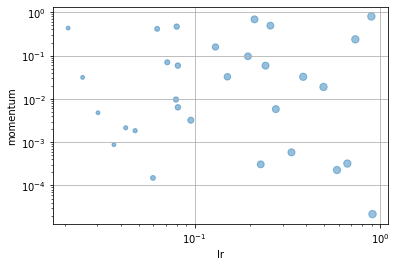

In [167]:
test_loss = hyperparam_df['loss_test']
test_accuracy = hyperparam_df['accuracy_test']
hyperparam_df.plot(x='lr', y='momentum', kind='scatter', logy=True, logx=True, grid=True, marker='o', s=100*test_accuracy**2, alpha=test_loss*.7)

In [ ]:
results = fit()

In [ ]:
pd.DataFrame(results)

In [ ]:
# model.score(vecs[~istrain], y[~istrain], sample_weight=df['count'][~istrain])

In [ ]:
# model.classes_


In [ ]:
names = ['Dewey', 'Kemal', 'Copeland', 'Vishvesh']
ourvecs = vectorizer.transform(names)
ourvecs = pd.DataFrame.sparse.from_spmatrix(ourvecs)
ourvecs.columns = vectorizer.get_feature_names_out()
ourvecs.index = list(zip(names, 'M'*len(names)))
ourvecs

In [ ]:
ourtensors = 

In [ ]:
names = ['Maria', 'Syndee', 'Aditi', 'Constance']
vecs = vectorizer.transform(names)
vecs = pd.DataFrame.sparse.from_spmatrix(vecs)
vecs.columns = vectorizer.get_feature_names_out()
vecs.index = list(zip(names, 'M'*len(names)))
pd.DataFrame(model.predict_proba(vecs)[:,0], index=vecs.index)

In [ ]:
class LogisticRegressionNumpyNN(LogisticRegressionNN):

    def __init__(self, *args, **kwargs):
         super().__init__(*args, **kwargs)

    def predict_proba(self, X):
        return self.forward(make_tensor(X))
    
    def predict(self, X):
        return (np.array(self.forward(make_tesnor(X))) > 0.5).astype(int)
    
# ', '.join([v for v in dir(LogisticRegression) if v[0] != '_'])